# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

In [1]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

Using TensorFlow backend.
/Users/phil/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [2]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [ ]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [4]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.2815979719161987 TLGT    US Equity
65 1.356967806816101 INO     US Equity
38 1.6263184547424316 LXRX    US Equity
76 1.8300398588180542 NVAX    US Equity
66 2.0877132415771484 CERS    US Equity
79 2.176175832748413 ZGNX    US Equity
81 2.4153707027435303 MNOV    US Equity
77 2.432579517364502 PDLI    US Equity
71 2.479269027709961 CRIS    US Equity
52 2.7961225509643555 IMMU    US Equity
17 2.874561309814453 EXEL    US Equity
75 3.100437641143799 GERN    US Equity
49 3.110214948654175 DEPO    US Equity
37 3.417987823486328 ARRY    US Equity
73 3.5709407329559326 AVDL    US Equity
67 3.6554181575775146 PACB    US Equity
48 3.8765335083007812 SGYP    US Equity
19 4.01953125 OPK     US Equity
42 4.117503643035889 RGEN    US Equity
55 4.152100086212158 BCRX    US Equity
31 4.240755558013916 HZNP    US Equity
72 4.248083114624023 PRTK    US Equity
82 4.316125869750977 ARWR    US Equity
80 4.6085205078125 CGEN    US Equity
69 4.850961685180664 RIGL    US Equi

Let's have a look on how well this auto-encoder works on a certain stock.

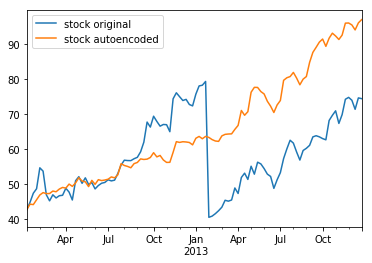

In [7]:
which_stock = 1

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

In [ ]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S25 2-norm difference:  4.89636
S45 2-norm difference:  13.768
S65 2-norm difference:  5.14921


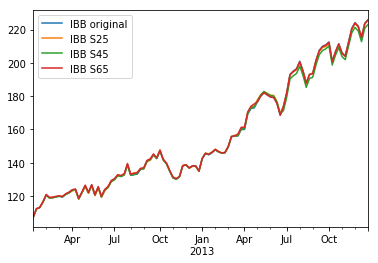

In [13]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    


# Phase 3: Validating

In [14]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

S25 2-norm difference:  771.718
S45 2-norm difference:  503.952
S65 2-norm difference:  382.832


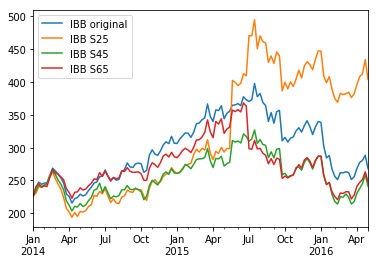

In [15]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [ ]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Text(0,0.5,'number of stocks in the portfolio')

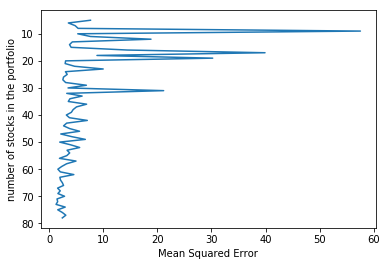

In [20]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 